This time series analysis hopes to find a coorelation between accident location, type of issue, time taken to resolve issue, time of day, day of week, and month of year. This will help predict when and where an accident is likely to happen.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [6]:
file = './Desktop/Real-Time_Traffic_Incident_Reports.csv'


In [7]:
df = pd.read_csv(file, parse_dates=['Published Date', 'Status Date'])
df.head()


,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03+00:00
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03+00:00
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,ARCHIVED,2020-04-17 21:55:03+00:00
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,ARCHIVED,2020-04-17 21:55:03+00:00
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,ARCHIVED,2020-04-17 23:30:04+00:00


The column names have spaces in them. This will prove to be a problem with creating visualizations later so I'm going to change the variable names for the applicable columns.

In [31]:
df=df.rename(columns = {'Published Date':'published_date'})
df=df.rename(columns = {'Status Date':'status_date'})
df=df.rename(columns = {'Issue Reported':'issue_reported'})
df=df.rename(columns = {'Traffic Report ID':'tr_ID'})
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,Status,status_date,issue_timespan
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03+00:00,0 days 02:24:04
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03+00:00,0 days 01:04:27
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,ARCHIVED,2020-04-17 21:55:03+00:00,0 days 00:30:00
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,ARCHIVED,2020-04-17 21:55:03+00:00,0 days 00:14:11
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,ARCHIVED,2020-04-17 23:30:04+00:00,0 days 02:29:09


Exploring the Data and Converting Datatypes

In [32]:
df.shape
#big enough

(249650, 10)

In [85]:
df.describe()
#I assume I only get one column because it's the only numerical data type(float)

,Latitude,Longitude,issue_timespan,issue_reported_value
count,249525.000000,249571.000000,249650,0.0
mean,30.245476,-97.551690,3 days 05:50:23.870238333,NaN
std,1.308834,4.211096,44 days 21:21:28.108638932,NaN
min,0.000000,-98.816154,-17577 days +05:40:00,NaN
25%,30.231876,-97.776950,0 days 00:21:00,NaN
50%,30.294128,-97.734295,0 days 00:42:21,NaN
75%,30.373668,-97.687038,0 days 01:25:00,NaN
max,31.077333,0.000000,233 days 08:49:00,NaN


In [34]:
df['Latitude'] = pd.to_numeric(df['Latitude'], errors = 'coerce')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249650 entries, 0 to 249649
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   tr_ID           249650 non-null  object             
 1   published_date  249650 non-null  datetime64[ns, UTC]
 2   issue_reported  249650 non-null  object             
 3   Location        249107 non-null  object             
 4   Latitude        249525 non-null  float64            
 5   Longitude       249571 non-null  float64            
 6   Address         249650 non-null  object             
 7   Status          247957 non-null  object             
 8   status_date     249650 non-null  datetime64[ns, UTC]
 9   issue_timespan  249650 non-null  timedelta64[ns]    
dtypes: datetime64[ns, UTC](2), float64(2), object(5), timedelta64[ns](1)
memory usage: 19.0+ MB
None


In [35]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249650 entries, 0 to 249649
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   tr_ID           249650 non-null  object             
 1   published_date  249650 non-null  datetime64[ns, UTC]
 2   issue_reported  249650 non-null  object             
 3   Location        249107 non-null  object             
 4   Latitude        249525 non-null  float64            
 5   Longitude       249571 non-null  float64            
 6   Address         249650 non-null  object             
 7   Status          247957 non-null  object             
 8   status_date     249650 non-null  datetime64[ns, UTC]
 9   issue_timespan  249650 non-null  timedelta64[ns]    
dtypes: datetime64[ns, UTC](2), float64(2), object(5), timedelta64[ns](1)
memory usage: 19.0+ MB


In [37]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

#So it may be better to create a new location variable as there are far less null values for longitude and latitude 
#than for location. Status can likely be removed entirely.
#Clearly the attempt to turn location into a float did not work. Also, instances of null in Latitude increased by 46.

,count,%
tr_ID,0,0.000000
published_date,0,0.000000
issue_reported,0,0.000000
Address,0,0.000000
status_date,0,0.000000
issue_timespan,0,0.000000
Longitude,79,0.031644
Latitude,125,0.050070
Location,543,0.217505
Status,1693,0.678149


In [38]:
df['issue_reported'].value_counts()
#Unsure about the meaning of some of these headings mean but the best way to categorize these issues in by 
#subtracting the published date from the status date and finding out how long these issues take to resolve.

Traffic Hazard                77168
Crash Urgent                  58699
Crash Service                 37408
COLLISION                     21856
TRFC HAZD/ DEBRIS             17586
zSTALLED VEHICLE               8930
Traffic Impediment             6255
COLLISION WITH INJURY          6000
LOOSE LIVESTOCK                5994
COLLISN/ LVNG SCN              4275
Stalled Vehicle                2853
COLLISION/PRIVATE PROPERTY      970
VEHICLE FIRE                    821
BLOCKED DRIV/ HWY               502
BOAT ACCIDENT                   102
AUTO/ PED                        66
TRAFFIC FATALITY                 65
ICY ROADWAY                      49
FLEET ACC/ INJURY                33
N / HZRD TRFC VIOL                7
OBSTRUCT HWY                      5
FLEET ACC/ FATAL                  3
HIGH WATER                        2
COLLISN / FTSRA                   1
Name: issue_reported, dtype: int64

In [16]:
issue_date = df[['issue_reported', 'published_date', 'status_date']]
print(issue_date.head())
#As mentioned above, subtracting the published date from the status date will help find out how long these issues 
#take to resolve which will be useful in helping avoid parts of town. 
#The date and time are listed together, which may come in handy when classifying the severity of issues, but the 
#date and time values will have to be seperated when we try to decipher seasonal and time of day data.

   issue_reported            published_date               status_date
0   Crash Service 2018-06-13 06:35:59+00:00 2018-06-13 09:00:03+00:00
1  Traffic Hazard 2018-06-13 10:15:36+00:00 2018-06-13 11:20:03+00:00
2    Crash Urgent 2020-04-17 21:25:03+00:00 2020-04-17 21:55:03+00:00
3  Traffic Hazard 2020-04-17 21:40:52+00:00 2020-04-17 21:55:03+00:00
4    Crash Urgent 2020-04-17 21:00:55+00:00 2020-04-17 23:30:04+00:00


In [17]:
df['Address'].value_counts()
#Clearly some Adresses are more prone to accidents. These appear to be a series of intersections that can also be
#identified through location data. Example: E Parmer Ln & Dessau Rd (177 issues reported) is location
#30.387004,-97.648592 (381 issues reported). This suggests that perhaps the location indicator may be more accurate
#even though addresses are easier to communicate

E Parmer Ln & Dessau Rd                      177
9300 S Ih 35 Svrd Sb                         164
E Riverside Dr & S Pleasant Valley Rd        157
Fm 969 Rd & N Fm 973 Rd                      154
Dessau Rd & E Parmer Ln                      150
                                            ... 
S Ih 35 Sb To Slaughter Ramp & S Ih 35 Sb      1
10212 River Plantation Dr                      1
OAK SPRINGS DR & AIRPORT BLVD                  1
2000 Scofield Ridge Pkwy                       1
4000-4500 ED BLUESTEIN BLVD NB                 1
Name: Address, Length: 82698, dtype: int64

In [18]:
address_date = df[['Address', 'published_date', 'status_date']]
print(issue_date.head())

   issue_reported            published_date               status_date
0   Crash Service 2018-06-13 06:35:59+00:00 2018-06-13 09:00:03+00:00
1  Traffic Hazard 2018-06-13 10:15:36+00:00 2018-06-13 11:20:03+00:00
2    Crash Urgent 2020-04-17 21:25:03+00:00 2020-04-17 21:55:03+00:00
3  Traffic Hazard 2020-04-17 21:40:52+00:00 2020-04-17 21:55:03+00:00
4    Crash Urgent 2020-04-17 21:00:55+00:00 2020-04-17 23:30:04+00:00


In [19]:
df['Location'].value_counts() 
#It may be a good a idea to remove outliers here and focus on high volume areas.
#Can we create a dataframe that uses a condition on the value_count() function to focus on high frequency areas?

#This no longer works after being changed to float data type.

(30.256997,-97.611818)    396
(30.387004,-97.648592)    381
(30.173724,-97.823807)    370
(30.164182,-97.692911)    349
(30.349292,-97.538573)    306
                         ... 
(30.332024,-97.704342)      1
(30.332453,-97.685939)      1
(30.393124,-97.846713)      1
(30.288104,-97.747037)      1
(30.481124,-97.894395)      1
Name: Location, Length: 116904, dtype: int64

Deleting and Inserting Columns

In [117]:
pub_day = df['published_date'].dt.dayofweek
df['published_day'] = pub_day
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,status_date,issue_timespan,issue_reported_value,timespan_sec,timespan_min,timespan_hrs,published,published_day,status_day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,NaN,8644.0,144.066667,2.401111,2,2,2
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,NaN,3867.0,64.450000,1.074167,2,2,2
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,NaN,1800.0,30.000000,0.500000,4,4,4
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,NaN,851.0,14.183333,0.236389,4,4,4
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,NaN,8949.0,149.150000,2.485833,4,4,4


In [108]:
pub_day = df['status_date'].dt.dayofweek
df['status_day'] = pub_day
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,status_date,issue_timespan,issue_reported_value,timespan_sec,timespan_min,timespan_hrs,published,published_day,status_day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,NaN,8644.0,144.066667,2.401111,2,2,2
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,NaN,3867.0,64.450000,1.074167,2,2,2
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,NaN,1800.0,30.000000,0.500000,4,4,4
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,NaN,851.0,14.183333,0.236389,4,4,4
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,NaN,8949.0,149.150000,2.485833,4,4,4


In [109]:
issue_time = df['status_date'] - df['published_date']
df['issue_timespan'] = issue_time
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,status_date,issue_timespan,issue_reported_value,timespan_sec,timespan_min,timespan_hrs,published,published_day,status_day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,NaN,8644.0,144.066667,2.401111,2,2,2
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,NaN,3867.0,64.450000,1.074167,2,2,2
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,NaN,1800.0,30.000000,0.500000,4,4,4
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,NaN,851.0,14.183333,0.236389,4,4,4
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,NaN,8949.0,149.150000,2.485833,4,4,4


In [110]:
issue_timespan_sec = df['issue_timespan'].value_counts()
df['issue_reported_value'] = issue_reported_value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249650 entries, 0 to 249649
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   tr_ID                 249650 non-null  object             
 1   published_date        249650 non-null  datetime64[ns, UTC]
 2   issue_reported        249650 non-null  object             
 3   Location              249107 non-null  object             
 4   Latitude              249525 non-null  float64            
 5   Longitude             249571 non-null  float64            
 6   Address               249650 non-null  object             
 7   status_date           249650 non-null  datetime64[ns, UTC]
 8   issue_timespan        249650 non-null  timedelta64[ns]    
 9   issue_reported_value  0 non-null       float64            
 10  timespan_sec          249650 non-null  float64            
 11  timespan_min          249650 non-null  float64      

In [121]:
avg_mean = df['issue_timespan'].mean()
print(avg_mean)
print(avg_mean.total_seconds())

3 days 05:50:23.870238333
280223.870238


In [122]:
#df = df.drop('Status', inplace=True)
#df.head()

In [123]:
issue_reported_value = df['issue_reported'].value_counts()
issue_reported_value




Traffic Hazard                77168
Crash Urgent                  58699
Crash Service                 37408
COLLISION                     21856
TRFC HAZD/ DEBRIS             17586
zSTALLED VEHICLE               8930
Traffic Impediment             6255
COLLISION WITH INJURY          6000
LOOSE LIVESTOCK                5994
COLLISN/ LVNG SCN              4275
Stalled Vehicle                2853
COLLISION/PRIVATE PROPERTY      970
VEHICLE FIRE                    821
BLOCKED DRIV/ HWY               502
BOAT ACCIDENT                   102
AUTO/ PED                        66
TRAFFIC FATALITY                 65
ICY ROADWAY                      49
FLEET ACC/ INJURY                33
N / HZRD TRFC VIOL                7
OBSTRUCT HWY                      5
FLEET ACC/ FATAL                  3
HIGH WATER                        2
COLLISN / FTSRA                   1
Name: issue_reported, dtype: int64

In [124]:
df['timespan_sec'] = df.issue_timespan.apply(lambda x: x.total_seconds())
df['timespan_min'] = df['timespan_sec']/60
df['timespan_hrs'] = df['timespan_min']/60
df.head()

,tr_ID,published_date,issue_reported,Location,Latitude,Longitude,Address,status_date,issue_timespan,issue_reported_value,timespan_sec,timespan_min,timespan_hrs,published,published_day,status_day
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00,0 days 02:24:04,NaN,8644.0,144.066667,2.401111,2,2,2
1,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00,0 days 01:04:27,NaN,3867.0,64.450000,1.074167,2,2,2
2,2A7A84FC69D56A2C379C274D2F0831442D3E7B8E_15871...,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00,0 days 00:30:00,NaN,1800.0,30.000000,0.500000,4,4,4
3,89D3B75BB5932F10D25B5852A9902DA26C3DF11A_15871...,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00,0 days 00:14:11,NaN,851.0,14.183333,0.236389,4,4,4
4,E7F9EFF0E81057A5C8FE41CABE4D9C6EEA82DAA0_15871...,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00,0 days 02:29:09,NaN,8949.0,149.150000,2.485833,4,4,4


In [154]:
over_day = df.loc[['timespan-hrs']] > 24.00
print(over_day)

KeyError: "None of [Index(['timespan-hrs'], dtype='object')] are in the [index]"

In [130]:
#df = df.drop('published', inplace=True)
#df = df.drop('issue_reported_value', inplace=True)
#df.head()


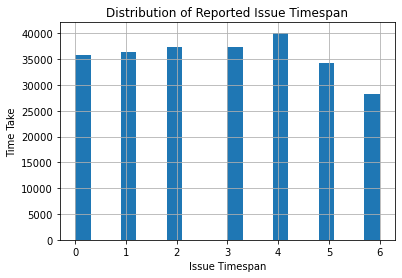

In [137]:
df.published_day.hist(bins=20)
plt.xlabel('Issue Timespan')
plt.ylabel('Time Take')
plt.title('Distribution of Reported Issue Timespan');

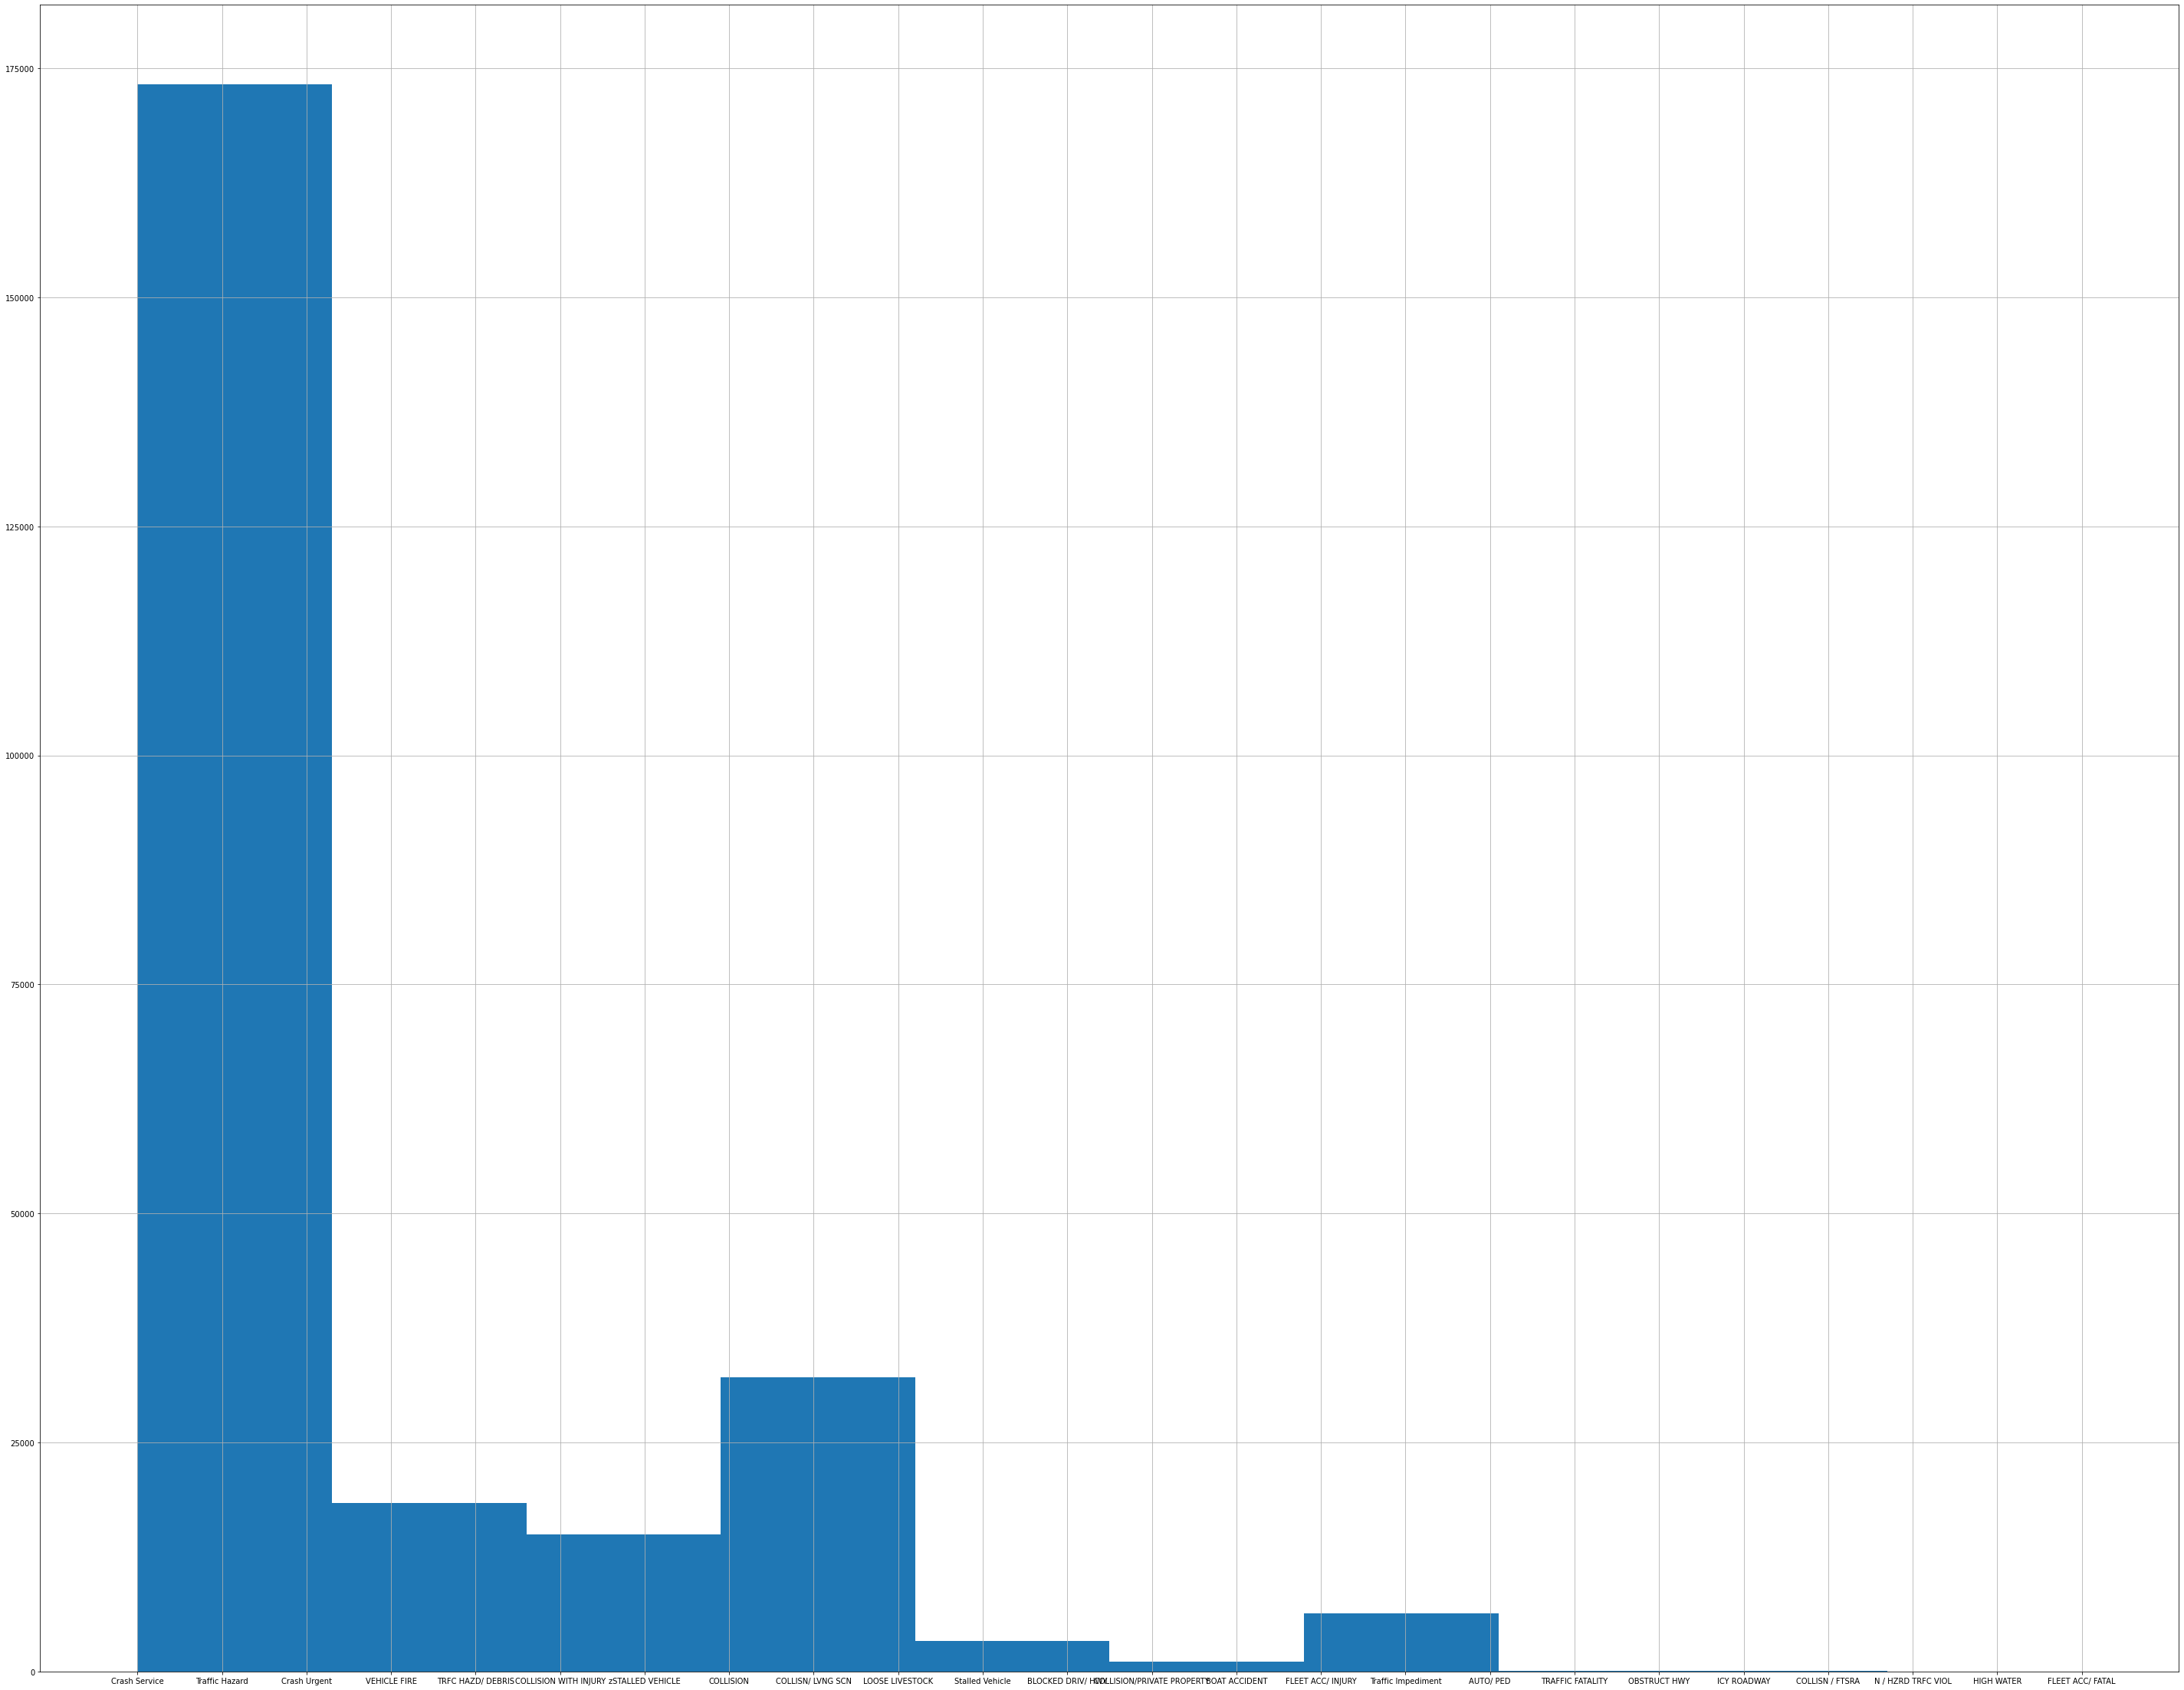

In [152]:
df.issue_reported.hist(figsize=(50,40))
plt.subplots_adjust(hspace=.5);